# Deep-LDA: Neural network-based discriminant CVs

### Import

In [1]:
# IMPORT PACKAGES
import torch
import pytorch_lightning as pl
import numpy as np
import matplotlib.pyplot as plt

# IMPORT HELPER FUNCTIONS
from mlcvs.utils.plot import muller_brown_potential, plot_isolines_2D, plot_metrics

# Set seed for reproducibility
torch.manual_seed(42)

/home/lbonati@iit.local/software/anaconda3/envs/pytorch/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Muller-Brown potential (2 states)

### Load MD data

In [1]:
from mlcvs.utils.io import create_dataset_from_files
from mlcvs.data import DictionaryDataModule

n_states = 2
filenames = [ f"data/muller-brown/unbiased/state-{i}/COLVAR" for i in range(n_states) ]

# load dataset
dataset, df = create_dataset_from_files(filenames,return_dataframe=True, filter_args={'regex':'p.x|p.y'})

# create datamodule for trainere
datamodule = DictionaryDataModule(dataset,lengths=[0.8,0.2])
datamodule

/home/lbonati@iit.local/software/anaconda3/envs/pytorch/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Class 0 dataframe shape:  (2001, 12)
Class 1 dataframe shape:  (2001, 12)

 - Loaded dataframe (4002, 12): ['time', 'p.x', 'p.y', 'p.z', 'ene', 'pot.bias', 'pot.ene_bias', 'lwall.bias', 'lwall.force2', 'uwall.bias', 'uwall.force2', 'labels']
 - Descriptors (4002, 2): ['p.x', 'p.y']


DictionaryDataModule(dataset -> DictionaryDataset("data": [4002, 2]"labels": [4002]),
		     train_loader -> FastDictionaryLoader(length=0.8, batch_size=0, shuffle=True),
		     valid_loader -> FastDictionaryLoader(length=0.2, batch_size=0, shuffle=True))

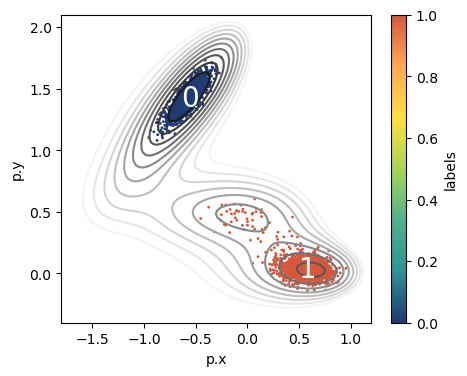

In [235]:
fig,ax = plt.subplots(figsize=(5,4),dpi=100)
# ploy MB isolines
plot_isolines_2D(muller_brown_potential,mode='contour',levels=np.linspace(0,24,12),ax=ax)
# plot points colored according to labels
df.plot.scatter('p.x','p.y',c='labels',s=1,cmap='fessa',ax=ax)
# draw state labels
for i in range(n_states):
    df_g = df.groupby('labels').mean()
    ax.text(x = df_g['p.x'].values[i]-0.075, 
            y = df_g['p.y'].values[i]-0.075,
            s = str(i), size=20, color='white')


### Define model

In [241]:
from mlcvs.cvs import DeepLDA_CV

n_components = n_states-1
nn_layers = [2,30,30,5]
nn_args = {'activation': 'relu'}
options= {'nn': nn_args}
# MODEL
model = DeepLDA_CV(nn_layers,n_states=n_states)

### Define Trainer & Fit

In [242]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from mlcvs.utils.trainer import MetricsCallback

# define callbacks
metrics = MetricsCallback()
early_stopping = EarlyStopping(monitor="valid_eigval_1_epoch", mode='max', min_delta=1e-3, patience=20)

# define trainer
trainer = pl.Trainer(callbacks=[metrics, early_stopping],
                     max_epochs=None, logger=None, enable_checkpointing=False)

# fit
trainer.fit( model, datamodule )

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/lbonati@iit.local/software/anaconda3/envs/pytorch/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(

  | Name   | Type          | Params | In sizes | Out sizes
----------------------------------------------------------------
0 | normIn | Normalization | 0      | [2]      | [2]      
1 | nn     | FeedForward   | 1.2 K  | [2]      | [5]      
2 | lda    | LDA           | 0      | [5]      | [1]      
----------------------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


Epoch 598: 100%|██████████| 2/2 [00:00<00:00, 146.30it/s, loss=-62.7]       


Learning curve

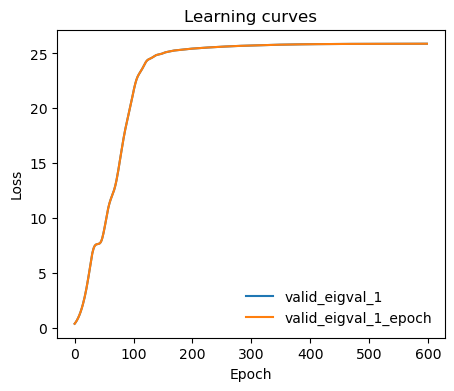

In [243]:
ax = plot_metrics(metrics.metrics, 
                  keys=[x for x in  metrics.metrics.keys() if 'valid_eigval' in x],#['train_loss_epoch','valid_loss'],
                  #linestyles=['-.','-'], colors=['fessa1','fessa5'],
                  yscale='linear')

### Analysis of the CV

CVs isolines

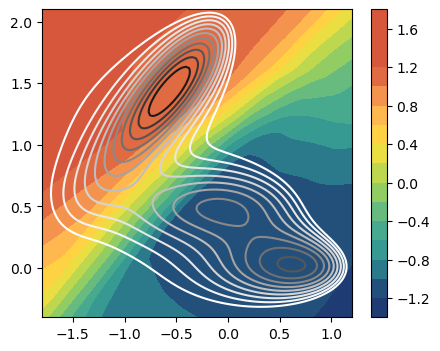

In [244]:
fig,axs = plt.subplots( 1, n_components, figsize=(5*n_components,4) )
if n_components == 1:
    axs = [axs]
for i in range(n_components):
    ax = axs[i]
    plot_isolines_2D(muller_brown_potential,levels=np.linspace(0,24,12),mode='contour',ax=ax)
    plot_isolines_2D(model, component=i, levels=15, vmin=-1.2,vmax=1.2, ax=ax)

CVs histogram

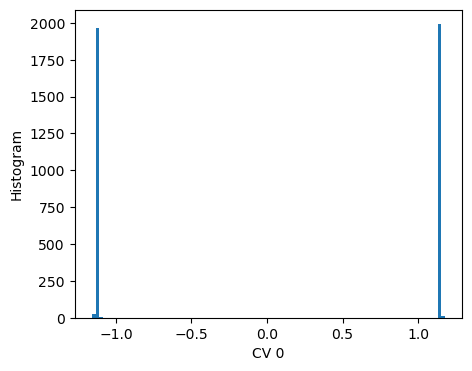

In [245]:
fig,axs = plt.subplots(1,n_components,figsize=(5*n_components,4))
if n_components == 1:
    axs = [axs]

X = dataset[:]['data']
with torch.no_grad():
    s = model(torch.Tensor(X)).numpy()

for i,ax in enumerate(axs):
    ax.hist(s[:,i],bins=100)
    ax.set_xlabel(f'CV {i}')
    ax.set_ylabel('Histogram')